# Uncertainty Quantification in Bayesian Deep Learning for Financial Time Series Forecasting
### MSc Project

Models: Baseline LSTM, MC Dropout, Deep Ensemble, Bayes by Backprop, Gradient-based Uncertainty Attribution (GUA)

## Setup

In [1]:
import random
from copy import deepcopy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, EMAIndicator, SMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preprocessing

In [2]:
# Download OHLCV for S&P 500 (adjusted), and context (VIX, 10Y yield)
start = "2010-01-01"
end = "2025-08-01"

px = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
px = px.rename(columns=str.lower)[['open','high','low','close','volume']].dropna()
px.index.name = "date"

vix = (
    yf.download("^VIX", start=start, end=end, auto_adjust=True)
      .rename(columns=str.lower)[['close']]
      .rename(columns={'close': 'vix_close'})
)

tnx = (
    yf.download("^TNX", start=start, end=end, auto_adjust=True)
      .rename(columns=str.lower)[['close']]
      .rename(columns={'close': 'us10y_yield'})
)

ctx = vix.join(tnx, how="outer").sort_index().ffill()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Core return features (no leakage: all derived from t or earlier)
df = px.copy()
df['ret_1'] = df['close'].pct_change(1)
df['ret_5'] = df['close'].pct_change(5)
df['ret_10'] = df['close'].pct_change(10)
df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
df['ret_1_lag1'] = df['ret_1'].shift(1)
df['ret_1_lag2'] = df['ret_1'].shift(2)

In [4]:
def ensure_series(x, name=None):
    """Coerce a pandas object to a 1D float Series with the same index."""
    if isinstance(x, pd.DataFrame):
        x = x.iloc[:, 0]
    s = pd.Series(np.asarray(x).reshape(-1), index=x.index)
    if name is not None:
        s.name = name
    return s.astype(float)

In [5]:
# Rolling stats (trend/volatility/volume structure)
# Realised volatility on returns
for w in [5, 10, 20, 60]:
    df[f'sma_{w}'] = df['close'].rolling(w).mean()
    df[f'vol_{w}'] = df['ret_1'].rolling(w).std()

# Price z-score vs 20-day mean/std
close_s = ensure_series(df['close'], 'close') # Ensure Series, not DataFrames
sma20_s = ensure_series(df['sma_20'], 'sma_20')
std20_s = ensure_series(close_s.rolling(20).std(), 'std20')

df['close_z_20'] = (close_s - sma20_s) / (std20_s + 1e-8)
df['ret_z_20'] = (df['ret_1'] - df['ret_1'].rolling(20).mean()) / (df['ret_1'].rolling(20).std() + 1e-8)

# Rolling volume signals
for w in [5, 20, 60]:
    df[f'volu_mean_{w}'] = df['volume'].rolling(w).mean()

volume_s = ensure_series(df['volume'], 'volume')
volm5_s = ensure_series(df['volu_mean_5'], 'volu_mean_5')
volm20_s = ensure_series(df['volu_mean_20'], 'volu_mean_20')
volm60_s = ensure_series(df['volu_mean_60'], 'volu_mean_60')

df['volu_ratio_5'] = volume_s / (volm5_s + 1e-8)
df['volu_ratio_20'] = volume_s / (volm20_s + 1e-8)
df['volu_ratio_60'] = volume_s / (volm60_s + 1e-8)

In [6]:
# Technical indicators
high_s = ensure_series(df['high'], 'high')
low_s = ensure_series(df['low'], 'low')
vol_s = ensure_series(df['volume'], 'volume')

# RSI(14)
df['rsi_14'] = RSIIndicator(close=close_s, window=14).rsi()

# MACD (12,26,9)
macd = MACD(close=close_s, window_slow=26, window_fast=12, window_sign=9)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_diff'] = macd.macd_diff()

# Bollinger Bands (20, 2)
bb = BollingerBands(close=close_s, window=20, window_dev=2)
df['bb_high'] = bb.bollinger_hband()
df['bb_low'] = bb.bollinger_lband()
df['bb_pct'] = (close_s - df['bb_low']) / (df['bb_high'] - df['bb_low'] + 1e-8)

# EMAs / SMAs
for w in [10, 20, 50, 100, 200]:
    df[f'ema_{w}'] = EMAIndicator(close=close_s, window=w).ema_indicator()
    df[f'sma_{w}'] = SMAIndicator(close=close_s, window=w).sma_indicator()

# ATR(14) (range/volatility)
df['atr_14'] = AverageTrueRange(high=high_s, low=low_s, close=close_s, window=14).average_true_range()

# OBV (volume trend)
df['obv'] = OnBalanceVolumeIndicator(close=close_s, volume=vol_s).on_balance_volume()

# Stochastic Oscillator (14,3)
stoch = StochasticOscillator(high=high_s, low=low_s, close=close_s, window=14, smooth_window=3)
df['stoch_k'] = stoch.stoch()
df['stoch_d'] = stoch.stoch_signal()

# MFI(14)
df['mfi_14'] = MFIIndicator(high=high_s, low=low_s, close=close_s, volume=vol_s, window=14).money_flow_index()

In [7]:
# Calendar (day-of-week cyclic encoding)
df['dow'] = pd.Index(df.index).dayofweek  # 0=Mon
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 5.0)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 5.0)
df = df.drop(columns=['dow'])

/var/folders/5b/m__nztsd5nl5h84q5f2pnr6h0000gn/T/ipykernel_89910/3318162182.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns=['dow'])


In [8]:
# Merge context (VIX, 10Y yield), forward-fill
df = df.join(ctx, how="left").ffill()

In [9]:
# Define target: next-day return (leakage-safe)
df['target'] = df['ret_1'].shift(-1)

# Drop warm-up NA rows from indicators and the last row from target shift
df = df.dropna().copy()

In [10]:
# Select a practitioner-style feature set
feature_cols = [
    # price & volume & returns
    'close','volume','ret_1','ret_5','ret_10','log_ret','ret_1_lag1','ret_1_lag2',
    # trend & volatility
    'sma_10','sma_20','sma_50','sma_100','sma_200',
    'ema_10','ema_20','ema_50','ema_100','ema_200',
    'vol_5','vol_10','vol_20','vol_60','close_z_20','ret_z_20',
    # bands & oscillators
    'bb_high','bb_low','bb_pct','rsi_14','stoch_k','stoch_d','mfi_14',
    # momentum (MACD)
    'macd','macd_signal','macd_diff',
    # range & volume flow
    'atr_14','obv',
    # calendar
    'dow_sin','dow_cos',
    # context
    'vix_close','us10y_yield'
]

In [11]:
# Build LSTM sequences (lookback window)
WINDOW = 60  # days lookback
X_list, y_list, idx_list = [], [], []
for i in range(WINDOW, len(df)):
    X_list.append(df[feature_cols].iloc[i-WINDOW:i].values) # shape (WINDOW, n_features)
    y_list.append(df['target'].iloc[i]) # scalar next-day return
    idx_list.append(df.index[i]) # time index of target

X = np.array(X_list, dtype=np.float32) # (N, WINDOW, n_features)
y = np.array(y_list, dtype=np.float32).reshape(-1, 1) # (N, 1)
idx = pd.Index(idx_list, name="date")

print(f"Raw sequences -> X: {X.shape}, y: {y.shape}")

Raw sequences -> X: (3658, 60, 40), y: (3658, 1)


In [12]:
# Time-ordered split (no shuffle)
split_ratio = 0.8
split_point = int(len(X) * split_ratio)

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
idx_train, idx_test = idx[:split_point], idx[split_point:]

In [13]:
# Scale features using train-only stats
scaler = StandardScaler(with_mean=True, with_std=True)

n_train, seq_len, n_feat = X_train.shape
X_train_2d = X_train.reshape(-1, n_feat)
X_test_2d = X_test.reshape(-1, n_feat)

X_train_scaled = scaler.fit_transform(X_train_2d).reshape(n_train, seq_len, n_feat)
X_test_scaled = scaler.transform(X_test_2d).reshape(X_test.shape[0], seq_len, n_feat)

y_scaler = StandardScaler(with_mean=True, with_std=True)
y_train_scaled = y_scaler.fit_transform(y_train)

In [14]:
# Convert to PyTorch tensors and DataLoaders
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

print("DataLoaders ready.")
print(f"Feature count: {len(feature_cols)}")

DataLoaders ready.
Feature count: 40


## Utility Functions

In [15]:
def picp(mean, std, trues):
    """Proportion of true values inside 95% prediction interval"""
    z = 1.96  # for 95% CI under Gaussian assumption
    lower = mean - z * std
    upper = mean + z * std

    within_interval = (trues >= lower) & (trues <= upper)
    
    return np.mean(within_interval)

def mpiw(mean, std):
    """Mean prediction interval width"""
    z = 1.96  # for 95% CI under Gaussian assumption
    lower = mean - z * std
    upper = mean + z * std
    
    return np.mean(upper - lower)

## Baseline Deterministic LSTM

In [16]:
# Define LSTM Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        return self.fc(last_out)

# Training Loop
def train_model(model, train_loader, num_epochs=50, lr=1e-3):
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimiser.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimiser.step()
            epoch_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

In [17]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.squeeze().tolist())
            actuals.extend(y_batch.squeeze().tolist())
    return predictions, actuals

# Train and Evaluate
input_size = X_train_scaled.shape[2]
model = LSTMRegressor(input_size=input_size)
train_model(model, train_loader)

preds, trues = evaluate_model(model, test_loader)

Epoch 10/50, Loss: 0.994944
Epoch 20/50, Loss: 0.722443
Epoch 30/50, Loss: 0.431461
Epoch 40/50, Loss: 0.207133
Epoch 50/50, Loss: 0.090149


In [18]:
# Inverse transform to get real price
preds_unscaled = y_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

# Compute metrics
rmse = root_mean_squared_error(y_test, preds_unscaled)
mae = mean_absolute_error(y_test, preds_unscaled)

print(f"Baseline LSTM — RMSE: {rmse:.6f} | MAE: {mae:.6f}")

Baseline LSTM — RMSE: 0.013939 | MAE: 0.010441


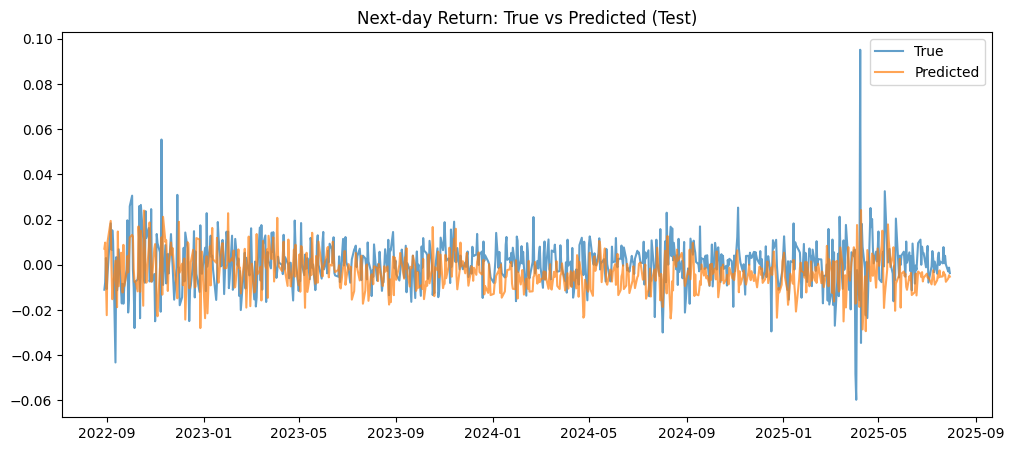

In [19]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(idx_test, y_test, label="True", alpha=0.7)
plt.plot(idx_test, preds_unscaled, label="Predicted", alpha=0.7)
plt.title("Next-day Return: True vs Predicted (Test)")
plt.legend()
plt.show()

## MC Dropout

In [20]:
# Define MC Dropout Model
class MCDropoutLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.5):
        super(MCDropoutLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Dropout on last output
        return self.fc(out)

In [21]:
# Train
input_size = X_train_scaled.shape[2]
mc_model = MCDropoutLSTM(input_size=input_size)
train_model(mc_model, train_loader)

Epoch 10/50, Loss: 0.995404
Epoch 20/50, Loss: 0.978181
Epoch 30/50, Loss: 0.833505
Epoch 40/50, Loss: 0.691036
Epoch 50/50, Loss: 0.617589


In [22]:
# MC Prediction
def predict_mc_dropout(model, X_tensor, T=50):
    model.eval()
    predictions = []

    # Enable dropout
    def enable_dropout(m):
        if isinstance(m, nn.Dropout):
            m.train()

    model.apply(enable_dropout)

    with torch.no_grad():
        for _ in range(T):
            preds = model(X_tensor).squeeze().cpu().numpy()
            predictions.append(preds)

    predictions = np.array(predictions)  # shape: (T, N)
    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    return pred_mean, pred_std

mc_mean, mc_std = predict_mc_dropout(mc_model, X_test_tensor, T=50)

In [23]:
# Inverse transform
mc_mean_unscaled = y_scaler.inverse_transform(np.array(mc_mean).reshape(-1, 1)).flatten()
mc_std_unscaled = y_scaler.inverse_transform(np.array(mc_std).reshape(-1, 1)).flatten()

# Compute metrics
mc_rmse = root_mean_squared_error(y_test, mc_mean_unscaled)
mc_mae = mean_absolute_error(y_test, mc_mean_unscaled)
mc_picp = picp(mc_mean_unscaled, mc_std_unscaled, y_test)
mc_mpiw = mpiw(mc_mean_unscaled, mc_std_unscaled)

print(f"MC Dropout RMSE: {mc_rmse:.6f}")
print(f"MC Dropout MAE: {mc_mae:.6f}")
print(f"MC Dropout PICP (95%): {mc_picp:.6f}")
print(f"MC Dropout MPIW: {mc_mpiw:.6f}")

MC Dropout RMSE: 0.011893
MC Dropout MAE: 0.008763
MC Dropout PICP (95%): 0.174858
MC Dropout MPIW: 0.004766


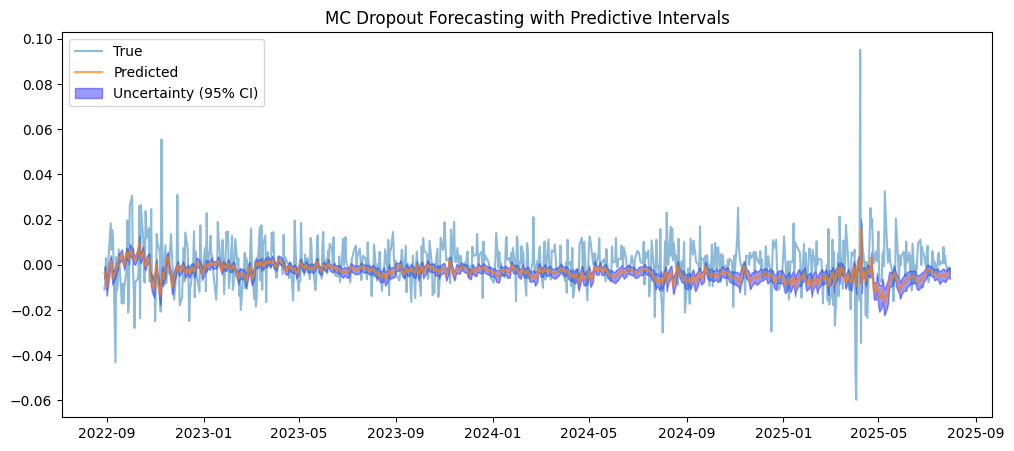

In [24]:
# Plot
mc_lower = mc_mean_unscaled - 1.96 * mc_std_unscaled
mc_upper = mc_mean_unscaled + 1.96 * mc_std_unscaled

plt.figure(figsize=(12, 5))
plt.plot(idx_test, y_test, label="True", alpha=0.5)
plt.plot(idx_test, mc_mean_unscaled, label="Predicted", alpha=0.7)
plt.fill_between(idx_test, mc_lower, mc_upper, alpha=0.4, label='Uncertainty (95% CI)', color='blue')
plt.title("MC Dropout Forecasting with Predictive Intervals")
plt.legend()
plt.show()

In [26]:
# Conformal Calibration
# Split test into calib + final (40% for calibration)
n_test = len(y_test)
n_cal  = int(0.4 * n_test) 

X_cal_tensor = X_test_tensor[:n_cal]
X_fin_tensor = X_test_tensor[n_cal:]
y_cal_real = np.asarray(y_test[:n_cal]).astype(float).ravel()
y_fin_real = np.asarray(y_test[n_cal:]).astype(float).ravel()

# Conformal (absolute residual quantile) on calibration
mc_mu_cal, mc_sd_cal = predict_mc_dropout(mc_model, X_cal_tensor, T=50)

mc_mu_cal_real = y_scaler.inverse_transform(np.array(mc_mu_cal).reshape(-1,1)).ravel()
mc_resid = np.abs(y_cal_real - mc_mu_cal_real)
mc_q = np.quantile(mc_resid, 0.95)

# Apply to final
mc_mu_fin, mc_sd_fin = predict_mc_dropout(mc_model, X_fin_tensor, T=50)
mc_mu_fin_real = y_scaler.inverse_transform(np.array(mc_mu_fin).reshape(-1,1)).ravel()
mc_lower_c = mc_mu_fin_real - mc_q
mc_upper_c = mc_mu_fin_real + mc_q

# Compute metrics
mc_picp_c = np.mean((y_test[n_cal:] >= mc_lower_c) & (y_test[n_cal:] <= mc_upper_c))
mc_mpiw_c = np.mean(mc_upper_c - mc_lower_c)
print(f"Conformal MC — PICP: {mc_picp_c:.6f} | MPIW: {mc_mpiw_c:.6f}")

Conformal MC — PICP: 0.945310 | MPIW: 0.042306


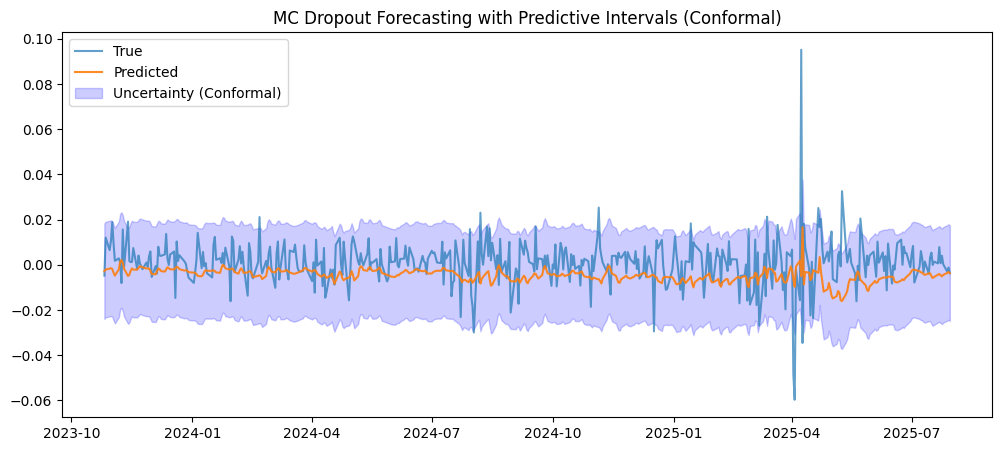

In [28]:
# Plot
idx_fin = idx_test[n_cal:]

plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, mc_mu_fin_real, label="Predicted", alpha=0.9)
plt.fill_between(idx_fin, mc_lower_c, mc_upper_c, alpha=0.2, label='Uncertainty (Conformal)', color='blue')
plt.title("MC Dropout Forecasting with Predictive Intervals (Conformal)")
plt.legend()
plt.show()

In [29]:
# Hybrid Conformal Calibration
y_std = float(getattr(y_scaler, "scale_", [1.0])[0]) # Std rescales linearly by the same factor used for y standardisation
mc_sd_cal_real = mc_sd_cal * y_std
mc_sd_fin_real = mc_sd_fin * y_std

# Normalised residuals on calibration slice
eps = 1e-12
mc_norm_resid = np.abs(y_cal_real - mc_mu_cal_real) / (mc_sd_cal_real + eps)

# Finite-sample conservative correction
alpha = 0.05
k = int(np.ceil((n_cal + 1) * (1 - alpha)))  # order statistic index
mc_q_norm = np.sort(mc_norm_resid)[min(k-1, len(mc_norm_resid)-1)]  # guard bounds

# Adaptive (heteroscedastic) conformal intervals on final slice
mc_lower_h = mc_mu_fin_real - mc_q_norm * mc_sd_fin_real
mc_upper_h = mc_mu_fin_real + mc_q_norm * mc_sd_fin_real

# Compute metrics
mc_picp_h  = np.mean((y_fin_real >= mc_lower_h) & (y_fin_real <= mc_upper_h))
mc_mpiw_h  = np.mean(mc_upper_h - mc_lower_h)

print(f"Hybrid (normalised conformal) — PICP: {mc_picp_h:.6f} | MPIW: {mc_mpiw_h:.6f}")

Hybrid (normalised conformal) — PICP: 0.927273 | MPIW: 0.040571


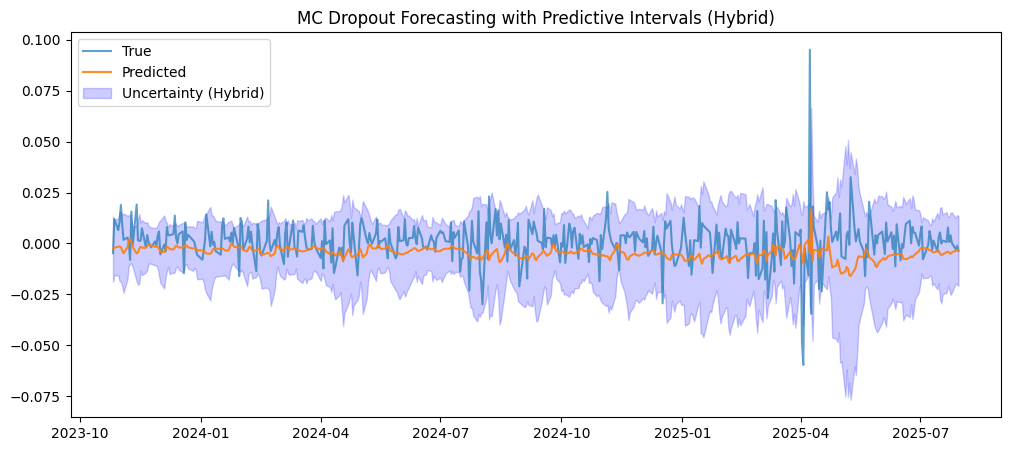

In [31]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, mc_mu_fin_real, label="Predicted", alpha=0.9)
plt.fill_between(idx_fin, mc_lower_h, mc_upper_h, alpha=0.2, label='Uncertainty (Hybrid)', color='blue')
plt.title("MC Dropout Forecasting with Predictive Intervals (Hybrid)")
plt.legend()
plt.show()

## Deep Ensembles

In [32]:
# Define Deep Ensembles model
class EnsembleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

In [33]:
def train_single_model(model, train_loader, epochs=50, lr=1e-3, device="cpu", seed=None):
    if seed is not None:
        torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    model.to(device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

def train_ensemble(n_members, input_size, train_loader, hidden_size=128, num_layers=3, dropout=0.0, epochs=50, lr=1e-3, 
                   device="cpu", base_seed=42):
    members = []
    for m in range(n_members):
        seed = base_seed + m
        model = EnsembleLSTM(input_size, hidden_size, num_layers, dropout)
        print(f"Ensemble {m}:")
        train_single_model(model, train_loader, epochs=epochs, lr=lr, device=device, seed=seed)
        members.append(deepcopy(model).cpu())  # keep on CPU for prediction
    return members

In [34]:
# Train
n_members = 5
input_size = X_train_scaled.shape[2]

ensemble_models = train_ensemble(
    n_members=n_members,
    input_size=input_size,
    train_loader=train_loader,
    hidden_size=128,
    num_layers=3,
    dropout=0.0,          # keep dropout off for deep ensemble
    epochs=70,
    lr=1e-3,
    device="cpu",
    base_seed=7
)

Ensemble 0:
Epoch 10/70, Loss: 0.961467
Epoch 20/70, Loss: 0.713066
Epoch 30/70, Loss: 0.363114
Epoch 40/70, Loss: 0.147790
Epoch 50/70, Loss: 0.056643
Epoch 60/70, Loss: 0.017232
Epoch 70/70, Loss: 0.010186
Ensemble 1:
Epoch 10/70, Loss: 0.964852
Epoch 20/70, Loss: 0.643960
Epoch 30/70, Loss: 0.287966
Epoch 40/70, Loss: 0.111701
Epoch 50/70, Loss: 0.046566
Epoch 60/70, Loss: 0.016938
Epoch 70/70, Loss: 0.014988
Ensemble 2:
Epoch 10/70, Loss: 0.970628
Epoch 20/70, Loss: 0.692213
Epoch 30/70, Loss: 0.372429
Epoch 40/70, Loss: 0.156412
Epoch 50/70, Loss: 0.069267
Epoch 60/70, Loss: 0.030176
Epoch 70/70, Loss: 0.014764
Ensemble 3:
Epoch 10/70, Loss: 0.984503
Epoch 20/70, Loss: 0.801635
Epoch 30/70, Loss: 0.431879
Epoch 40/70, Loss: 0.191799
Epoch 50/70, Loss: 0.079976
Epoch 60/70, Loss: 0.037181
Epoch 70/70, Loss: 0.022370
Ensemble 4:
Epoch 10/70, Loss: 0.968467
Epoch 20/70, Loss: 0.702841
Epoch 30/70, Loss: 0.382134
Epoch 40/70, Loss: 0.156216
Epoch 50/70, Loss: 0.065012
Epoch 60/70, Los

In [36]:
# Predict
@torch.no_grad()
def predict_ensemble(members, X_tensor, device="cpu"):
    preds = []
    for model in members:
        model.eval()
        model.to(device)
        out = model(X_tensor.to(device)).squeeze(1).cpu().numpy()  # shape (N,)
        preds.append(out)
    preds = np.stack(preds, axis=0)  # (M, N)
    mean_pred = preds.mean(axis=0)   # (N,)
    std_pred = preds.std(axis=0)     # (N,)
    return mean_pred, std_pred, preds

ens_mean, ens_std, _ = predict_ensemble(ensemble_models, X_test_tensor)

In [76]:
# Inverse transform
ens_mean_unscaled = y_scaler.inverse_transform(np.array(ens_mean).reshape(-1, 1)).flatten()
ens_std_unscaled = y_scaler.inverse_transform(np.array(ens_std).reshape(-1, 1)).flatten()

# Compute metrics
ens_rmse = root_mean_squared_error(y_test, ens_mean_unscaled)
ens_mae = mean_absolute_error(y_test, ens_mean_unscaled)
ens_picp = picp(ens_mean_unscaled, ens_std_unscaled, y_test)
ens_mpiw = mpiw(ens_mean_unscaled, ens_std_unscaled)

print(f"Deep Ensemble (M={n_members})")
print(f"RMSE: {ens_rmse:.6f}")
print(f"MAE:  {ens_mae:.6f}")
print(f"PICP (95%): {ens_picp:.6f}")
print(f"MPIW: {ens_mpiw:.6f}")

Deep Ensemble (M=5)
RMSE: 0.013263
MAE:  0.009792
PICP (95%): 0.603687
MPIW: 0.021158


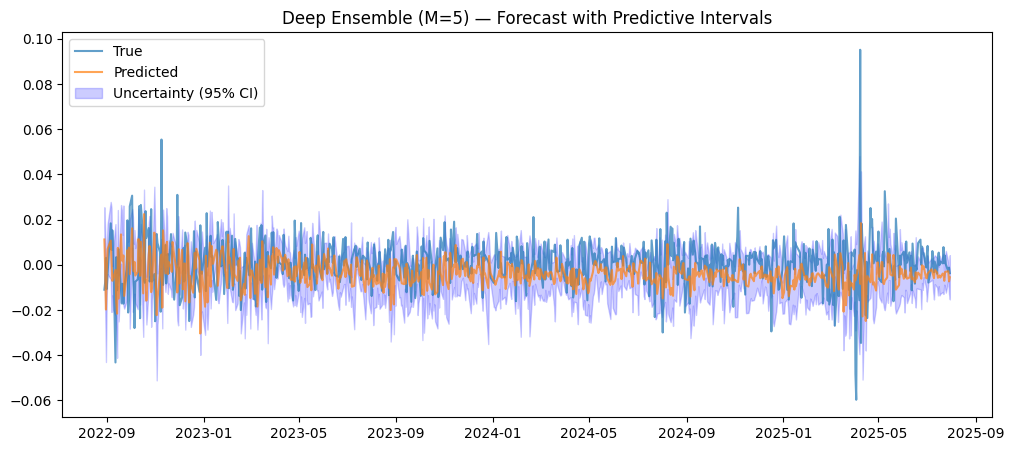

In [38]:
# Plot
ens_lower = ens_mean_unscaled - 1.96 * ens_std_unscaled
ens_upper = ens_mean_unscaled + 1.96 * ens_std_unscaled

plt.figure(figsize=(12, 5))
plt.plot(idx_test, y_test, label="True", alpha=0.7)
plt.plot(idx_test, ens_mean_unscaled, label="Predicted", alpha=0.7)
plt.fill_between(idx_test, ens_lower, ens_upper, alpha=0.2, label='Uncertainty (95% CI)', color='blue')
plt.title(f"Deep Ensemble (M={n_members}) — Forecast with Predictive Intervals")
plt.legend()
plt.show()

In [40]:
# Conformal Calibration
n_test = len(y_test)
n_cal  = int(0.4 * n_test)

X_cal_tensor = X_test_tensor[:n_cal]
X_fin_tensor = X_test_tensor[n_cal:]
y_cal_real = np.asarray(y_test[:n_cal]).astype(float).ravel()
y_fin_real = np.asarray(y_test[n_cal:]).astype(float).ravel()

# Conformal (absolute residual quantile) on calibration & final
ens_mu_cal, ens_sd_cal, _ = predict_ensemble(ensemble_models, X_cal_tensor)
ens_mu_fin, ens_sd_fin, _ = predict_ensemble(ensemble_models, X_fin_tensor)

# Invert to real scale
ens_mu_cal_real = y_scaler.inverse_transform(np.array(ens_mu_cal).reshape(-1,1)).ravel()
ens_mu_fin_real = y_scaler.inverse_transform(np.array(ens_mu_fin).reshape(-1,1)).ravel()

ens_resid = np.abs(y_cal_real - ens_mu_cal_real)
ens_q = np.quantile(ens_resid, 0.95)
ens_lower_c = ens_mu_fin_real - ens_q
ens_upper_c = ens_mu_fin_real + ens_q

# Compute metrics
ens_picp_c = np.mean((y_fin_real >= ens_lower_c) & (y_fin_real <= ens_upper_c))
ens_mpiw_c = np.mean(ens_upper_c - ens_lower_c)
print(f"Conformal MC — PICP: {ens_picp_c:.6f} | MPIW: {ens_mpiw_c:.6f}")

Conformal MC — PICP: 0.965909 | MPIW: 0.055071


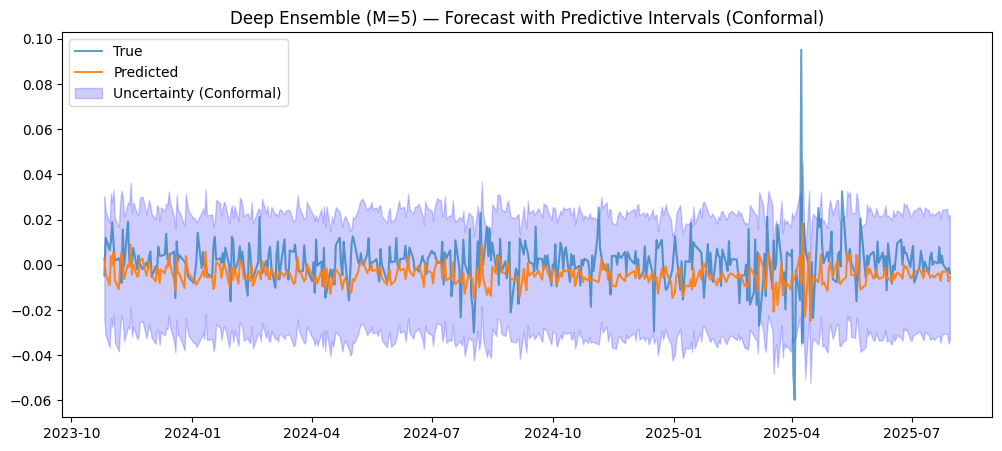

In [41]:
# Plot
idx_fin = idx_test[n_cal:]

plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, ens_mu_fin_real, label="Predicted", alpha=0.9)
plt.fill_between(idx_fin, ens_lower_c, ens_upper_c, alpha=0.2, label='Uncertainty (Conformal)', color='blue')
plt.title(f"Deep Ensemble (M={n_members}) — Forecast with Predictive Intervals (Conformal)")
plt.legend()
plt.show()

In [42]:
# Hybrid Conformal Calibration
y_std = float(getattr(y_scaler, "scale_", [1.0])[0]) # Rescale y
ens_sd_cal_real = ens_sd_cal * y_std
ens_sd_fin_real = ens_sd_fin * y_std

# Normalised residuals on calibration slice
eps = 1e-12
ens_norm_resid = np.abs(y_cal_real - ens_mu_cal_real) / (ens_sd_cal_real + eps)

# Finite-sample conservative correction
alpha = 0.05
k = int(np.ceil((n_cal + 1) * (1 - alpha)))  # order statistic index
ens_q_norm = np.sort(ens_norm_resid)[min(k-1, len(ens_norm_resid)-1)]  # guard bounds

# Adaptive (heteroscedastic) conformal intervals on final slice
ens_lower_h = ens_mu_fin_real - ens_q_norm * ens_sd_fin_real
ens_upper_h = ens_mu_fin_real + ens_q_norm * ens_sd_fin_real

# Compute metrics
ens_picp_h = np.mean((y_fin_real >= ens_lower_h) & (y_fin_real <= ens_upper_h))
ens_mpiw_h = np.mean(ens_upper_h - ens_lower_h)

print(f"Hybrid (normalised conformal) — PICP: {ens_picp_h:.6f} | MPIW: {ens_mpiw_h:.6f}")

Hybrid (normalised conformal) — PICP: 0.834091 | MPIW: 0.036889


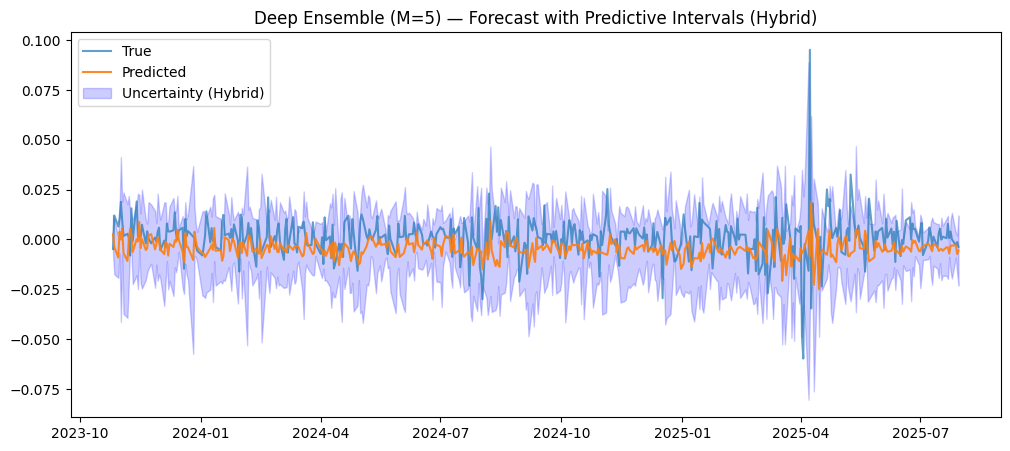

In [43]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, ens_mu_fin_real, label="Predicted", alpha=0.9)
plt.fill_between(idx_fin, ens_lower_h, ens_upper_h, alpha=0.2, label='Uncertainty (Hybrid)', color='blue')
plt.title(f"Deep Ensemble (M={n_members}) — Forecast with Predictive Intervals (Hybrid)")
plt.legend()
plt.show()

## Bayes by Backprop

In [44]:
# Bayesian Linear layer (mean-field Gaussian)
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_sigma=1.0):
        super().__init__()
        # Variational parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.1, 0.1))
        self.weight_logvar = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5.0, -4.0))
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.1, 0.1))
        self.bias_logvar = nn.Parameter(torch.Tensor(out_features).uniform_(-5.0, -4.0))
        # Prior (zero-mean isotropic Gaussian)
        self.prior_sigma = prior_sigma
        self.prior_var = prior_sigma ** 2

    def forward(self, x):
        # Reparameterisation: w = mu + sigma * eps
        weight_sigma = torch.exp(0.5 * self.weight_logvar)
        bias_sigma   = torch.exp(0.5 * self.bias_logvar)
        w = self.weight_mu + weight_sigma * torch.randn_like(self.weight_mu)
        b = self.bias_mu   + bias_sigma   * torch.randn_like(self.bias_mu)
        return F.linear(x, w, b)

    def kl(self):
        # Closed-form for diagonal Gaussians
        # Sum over weights and biases
        weight_kl = 0.5 * torch.sum(
            (torch.exp(self.weight_logvar) + self.weight_mu**2) / self.prior_var
            - 1.0 - self.weight_logvar + math.log(self.prior_var)
        )
        bias_kl = 0.5 * torch.sum(
            (torch.exp(self.bias_logvar) + self.bias_mu**2) / self.prior_var
            - 1.0 - self.bias_logvar + math.log(self.prior_var)
        )
        return weight_kl + bias_kl

In [45]:
# Bayes by Backprop LSTM: deterministic LSTM encoder + Bayesian linear head
class BBB_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, prior_sigma=1.0):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.head = BayesianLinear(hidden_size, 1, prior_sigma=prior_sigma)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)

    def kl(self):
        return self.head.kl()

In [46]:
def train_bbb(model, train_loader, epochs=60, lr=1e-3, device="cpu", kl_scale_strategy="linear", prior_sigma=1.0):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    n_batches_per_epoch = len(train_loader)

    def kl_weight(epoch_idx, batch_idx):
        # Anneal KL from 0 -> 1 across training for stability
        if kl_scale_strategy == "linear":
            total_steps = epochs * n_batches_per_epoch
            step = epoch_idx * n_batches_per_epoch + batch_idx + 1
            return min(1.0, step / total_steps)
        else:
            return 1.0

    for epoch in range(epochs):
        model.train()
        running = 0.0
        for bidx, (xb, yb) in enumerate(train_loader):
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            data_loss = mse(pred, yb)
            kl = model.kl()
            beta = kl_weight(epoch, bidx)
            loss = data_loss + beta * kl / xb.shape[0]  # normalise KL by batch size
            loss.backward()
            opt.step()
            running += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {running/len(train_loader):.6f}")

In [47]:
# Train
bbb_model = BBB_LSTM(input_size=X_train_scaled.shape[2], hidden_size=128, num_layers=3, prior_sigma=1.0)
train_bbb(bbb_model, train_loader, epochs=80, lr=1e-3, device="cpu", kl_scale_strategy="linear")

Epoch 10/80 | Loss: 1.426369
Epoch 20/80 | Loss: 1.709652
Epoch 30/80 | Loss: 1.685979
Epoch 40/80 | Loss: 1.421218
Epoch 50/80 | Loss: 1.207192
Epoch 60/80 | Loss: 0.974271
Epoch 70/80 | Loss: 0.773887
Epoch 80/80 | Loss: 0.609023


In [48]:
# Predict
@torch.no_grad()
def predict_bbb(model, X_tensor, T=100, device="cpu"):
    model.eval()
    model.to(device)
    preds = []
    for _ in range(T):
        out = model(X_tensor.to(device)).squeeze(1).cpu().numpy()  # (N,)
        preds.append(out)
    preds = np.stack(preds, axis=0)  # (T, N)
    mean_pred = preds.mean(axis=0)
    std_pred  = preds.std(axis=0)
    return mean_pred, std_pred, preds

bbb_mean, bbb_std, _ = predict_bbb(bbb_model, X_test_tensor, T=100)

In [77]:
# Inverse transform
bbb_mean_unscaled = y_scaler.inverse_transform(np.array(bbb_mean).reshape(-1, 1)).flatten()
bbb_std_unscaled = y_scaler.inverse_transform(np.array(bbb_std).reshape(-1, 1)).flatten()

# Compute metrics
bbb_rmse = root_mean_squared_error(y_test, bbb_mean_unscaled)
bbb_mae = mean_absolute_error(y_test, bbb_mean_unscaled)
bbb_picp = picp(bbb_mean_unscaled, bbb_std_unscaled, y_test)
bbb_mpiw = mpiw(bbb_mean_unscaled, bbb_std_unscaled)

print("Bayes by Backprop")
print(f"RMSE: {bbb_rmse:.6f}")
print(f"MAE:  {bbb_mae:.6f}")
print(f"PICP (95%): {bbb_picp:.6f}")
print(f"MPIW: {bbb_mpiw:.6f}")

Bayes by Backprop
RMSE: 0.015325
MAE:  0.011629
PICP (95%): 0.288343
MPIW: 0.012243


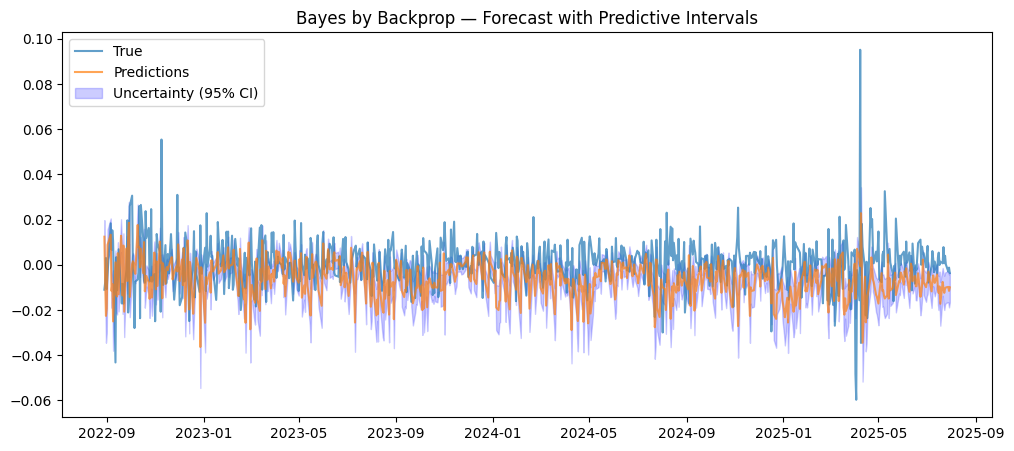

In [50]:
# Plot
bbb_lower = bbb_mean_unscaled - 1.96 * bbb_std_unscaled
bbb_upper = bbb_mean_unscaled + 1.96 * bbb_std_unscaled

plt.figure(figsize=(12, 5))
plt.plot(idx_test, y_test, label="True", alpha=0.7)
plt.plot(idx_test, bbb_mean_unscaled, label="Predictions", alpha=0.7)
plt.fill_between(idx_test, bbb_lower, bbb_upper, alpha=0.2, label='Uncertainty (95% CI)', color='blue')
plt.title("Bayes by Backprop — Forecast with Predictive Intervals")
plt.legend()
plt.show()

In [51]:
# Conformal Calibration
n_test = len(y_test)
n_cal  = int(0.4 * n_test)

X_cal_tensor = X_test_tensor[:n_cal]
X_fin_tensor = X_test_tensor[n_cal:]
y_cal_real = np.asarray(y_test[:n_cal]).astype(float).ravel()
y_fin_real = np.asarray(y_test[n_cal:]).astype(float).ravel()

# Conformal (absolute residual quantile) on calibration & final
bbb_mu_cal, bbb_sd_cal, _ = predict_bbb(bbb_model, X_cal_tensor)
bbb_mu_fin, bbb_sd_fin, _ = predict_bbb(bbb_model, X_fin_tensor)

bbb_mu_cal_real = y_scaler.inverse_transform(np.array(bbb_mu_cal).reshape(-1,1)).ravel()
bbb_mu_fin_real = y_scaler.inverse_transform(np.array(bbb_mu_fin).reshape(-1,1)).ravel()

bbb_resid = np.abs(y_cal_real - bbb_mu_cal_real)
bbb_q = np.quantile(bbb_resid, 0.95)
bbb_lower_c = bbb_mu_fin_real - bbb_q
bbb_upper_c = bbb_mu_fin_real + bbb_q

# Compute metrics
bbb_picp_c = np.mean((y_fin_real >= bbb_lower_c) & (y_fin_real <= bbb_upper_c))
bbb_mpiw_c = np.mean(bbb_upper_c - bbb_lower_c)
print(f"Conformal MC — PICP: {bbb_picp_c:.6f} | MPIW: {bbb_mpiw_c:.6f}")

Conformal MC — PICP: 0.954545 | MPIW: 0.064134


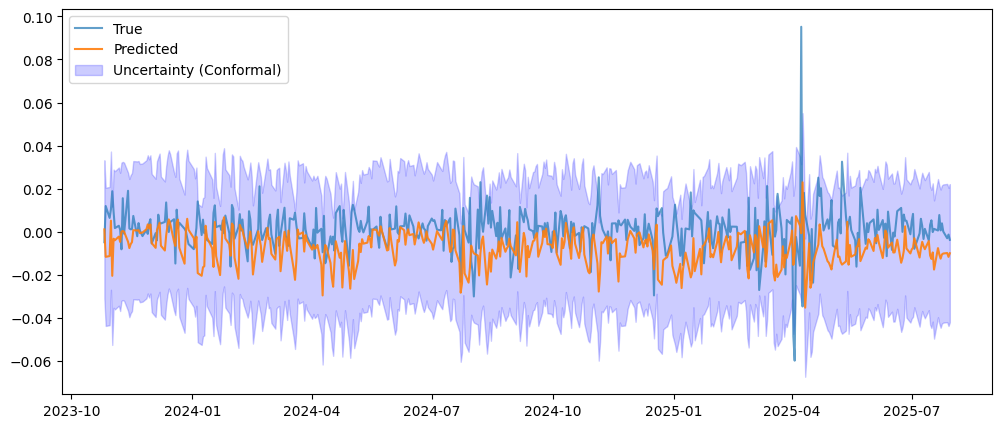

In [52]:
# Plot
idx_fin = idx_test[n_cal:]

plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, bbb_mu_fin_real, label="Predicted", alpha=0.9)
plt.fill_between(idx_fin, bbb_lower_c, bbb_upper_c, alpha=0.2, label='Uncertainty (Conformal)', color='blue')
plt.legend()
plt.savefig("forecast_c.png")
plt.show()

In [53]:
# Hybrid Conformal Calibration
y_std = float(getattr(y_scaler, "scale_", [1.0])[0]) # Rescale y
bbb_sd_cal_real = bbb_sd_cal * y_std
bbb_sd_fin_real = bbb_sd_fin * y_std

# Normalised residuals on calibration slice
eps = 1e-12
bbb_norm_resid = np.abs(y_cal_real - bbb_mu_cal_real) / (bbb_sd_cal_real + eps)

# Finite-sample conservative correction
alpha = 0.05
k = int(np.ceil((n_cal + 1) * (1 - alpha)))  # order statistic index
bbb_q_norm = np.sort(bbb_norm_resid)[min(k-1, len(bbb_norm_resid)-1)]  # guard bounds

# Adaptive (heteroscedastic) conformal intervals on final slice
bbb_lower_h = bbb_mu_fin_real - bbb_q_norm * bbb_sd_fin_real
bbb_upper_h = bbb_mu_fin_real + bbb_q_norm * bbb_sd_fin_real

# Compute metrics
bbb_picp_h = np.mean((y_fin_real >= bbb_lower_h) & (y_fin_real <= bbb_upper_h))
bbb_mpiw_h = np.mean(bbb_upper_h - bbb_lower_h)

print(f"Hybrid (normalised conformal) — PICP: {bbb_picp_h:.6f} | MPIW: {bbb_mpiw_h:.6f}")

Hybrid (normalised conformal) — PICP: 0.861364 | MPIW: 0.036307


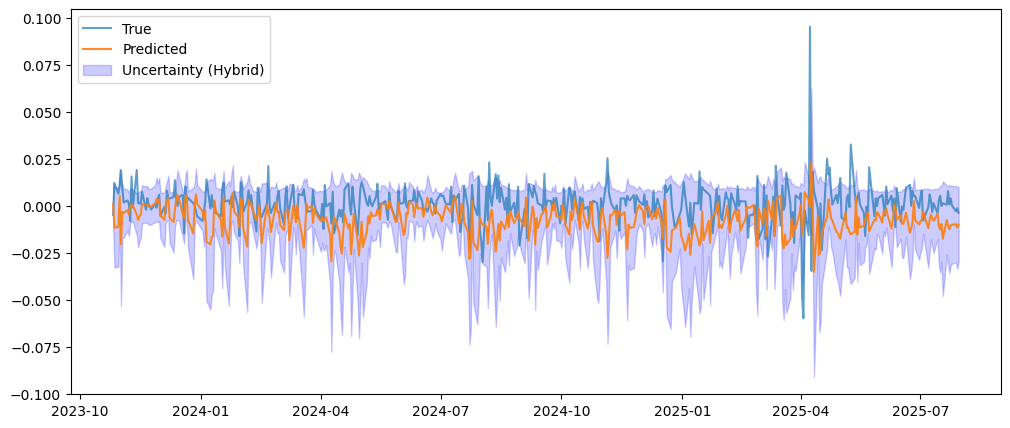

In [54]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, bbb_mu_fin_real, label="Predicted", alpha=0.9)
plt.fill_between(idx_fin, bbb_lower_h, bbb_upper_h, alpha=0.2, label='Uncertainty (Hybrid)', color='blue')
plt.legend()
plt.savefig("forecast_h.png")
plt.show()

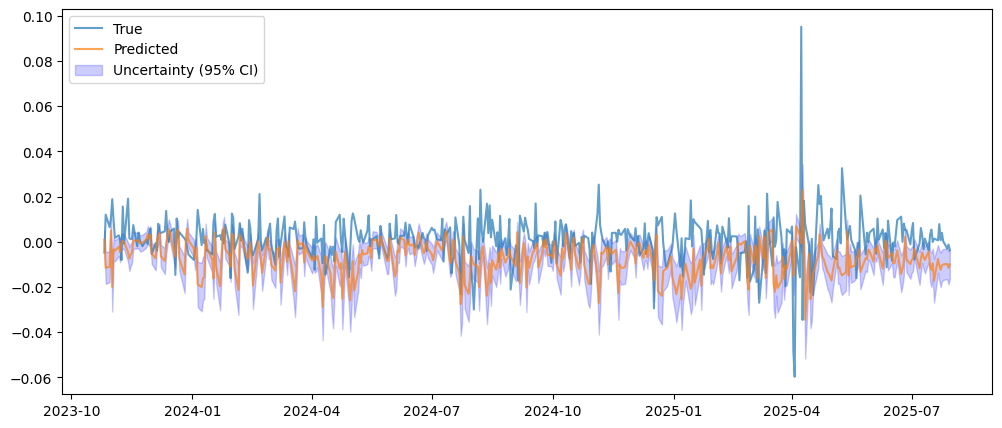

In [55]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(idx_fin, y_test[n_cal:], label="True", alpha=0.7)
plt.plot(idx_fin, bbb_mean_unscaled[n_cal:], label="Predicted", alpha=0.7)
plt.fill_between(idx_fin, bbb_lower[n_cal:], bbb_upper[n_cal:], alpha=0.2, label='Uncertainty (95% CI)', color='blue')
plt.legend()
plt.savefig("forecast_r.png")
plt.show()

## Gradient-Based Uncertainty Attribution (GUA)

In [56]:
def compute_feature_level_uncertainty_mc(model, test_loader, T=50):
    model.train()  # Enable dropout for MC Dropout
    feature_contributions = []

    for X_batch, _ in test_loader:
        X_batch = X_batch.clone().detach().requires_grad_(True)  # Track gradients

        preds = []
        for _ in range(T):
            y_pred = model(X_batch)  # (batch_size, 1)
            preds.append(y_pred)

        # (T, batch, 1) → variance: (batch, 1)
        preds_tensor = torch.stack(preds, dim=0)  # (T, B, 1)
        var_tensor = torch.var(preds_tensor, dim=0)  # (B, 1)

        # Backpropagate the uncertainty (sum of variances)
        var_tensor.sum().backward()

        # Get gradients: (batch, seq_len, num_features)
        grads = X_batch.grad.detach().cpu().numpy()

        # Aggregate gradient magnitudes per feature (over time steps)
        # Result: (batch, num_features)
        grads_per_feature = np.linalg.norm(grads, axis=1)
        feature_contributions.append(grads_per_feature)

    # (N, num_features)
    feature_contributions = np.vstack(feature_contributions)
    # (num_features,)
    mean_contributions = np.mean(feature_contributions, axis=0)
    return mean_contributions

In [57]:
# Compute feature attributions for MC model
mc_mean_attribution = compute_feature_level_uncertainty_mc(mc_model, test_loader, T=50)

In [58]:
# Sort by values (descending)
mc_sorted_indices = np.argsort(mc_mean_attribution)[::-1]
mc_sorted_values = mc_mean_attribution[mc_sorted_indices]
mc_sorted_labels = [feature_cols[i] for i in mc_sorted_indices]

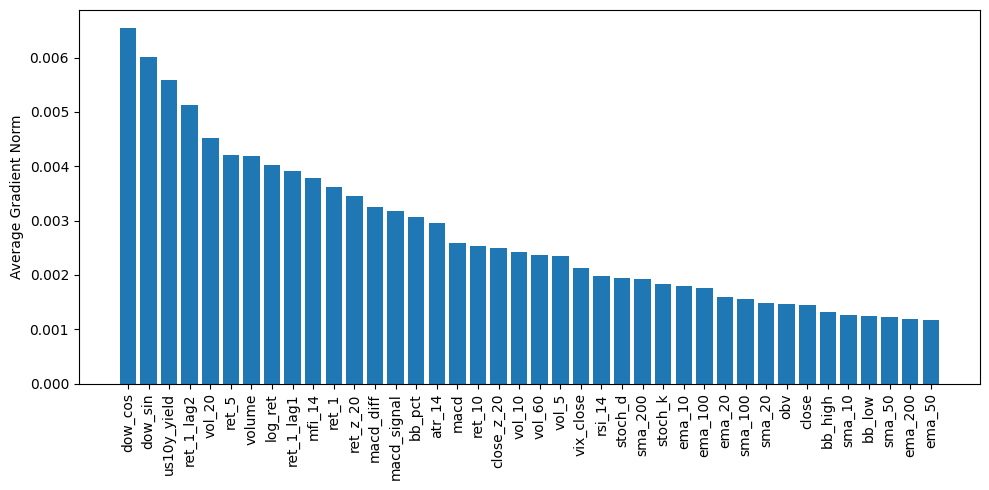

In [59]:
# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(mc_sorted_labels)), mc_sorted_values)
plt.xticks(range(len(mc_sorted_labels)), mc_sorted_labels, rotation=90)
plt.ylabel("Average Gradient Norm")
plt.tight_layout()
plt.show()

In [60]:
def compute_feature_level_uncertainty_ensemble(members, test_loader, device="cpu"):
    feature_contributions = []

    for X_batch, _ in test_loader:
        X_batch = X_batch.clone().detach().requires_grad_(True).to(device)

        preds = []
        for model in members:
            model.eval()
            model.to(device)
            y_pred = model(X_batch)  # (batch_size, 1)
            preds.append(y_pred)

        # Stack ensemble predictions: (M, B, 1)
        preds_tensor = torch.stack(preds, dim=0)

        # Variance across ensemble members: (B, 1)
        var_tensor = torch.var(preds_tensor, dim=0)

        # Backprop through variance
        var_tensor.sum().backward()

        # Gradients: (B, seq_len, num_features)
        grads = X_batch.grad.detach().cpu().numpy()

        # Aggregate per feature (collapse over seq_len)
        grads_per_feature = np.linalg.norm(grads, axis=1)  # (B, num_features)
        feature_contributions.append(grads_per_feature)

    # Concatenate across batches → (N, num_features)
    feature_contributions = np.vstack(feature_contributions)

    # Average per feature
    mean_contributions = np.mean(feature_contributions, axis=0)

    return mean_contributions

In [61]:
# Compute feature attributions for Deep Ensembles model
ens_mean_attribution = compute_feature_level_uncertainty_ensemble(ensemble_models, test_loader)

In [62]:
# Sort by values (descending)
ens_sorted_indices = np.argsort(ens_mean_attribution)[::-1]
ens_sorted_values = ens_mean_attribution[ens_sorted_indices]
ens_sorted_labels = [feature_cols[i] for i in ens_sorted_indices]

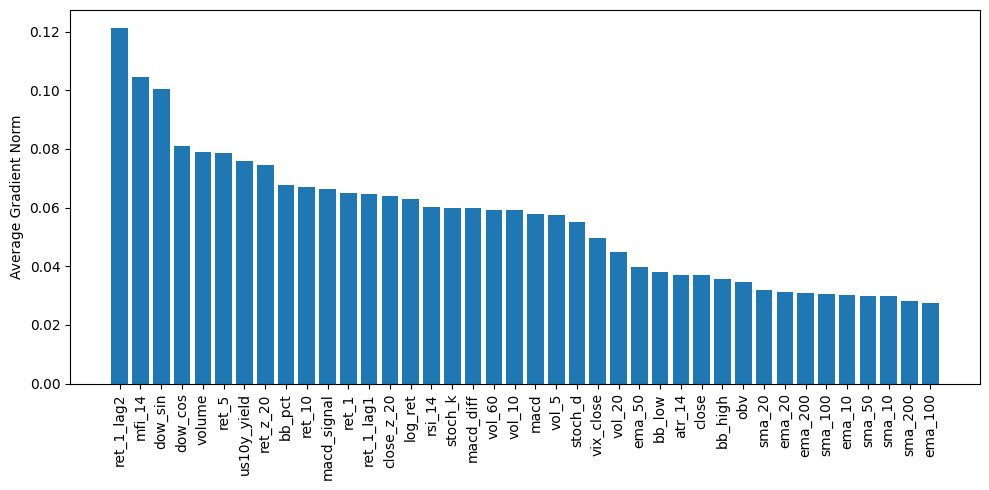

In [63]:
# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(ens_sorted_labels)), ens_sorted_values)
plt.xticks(range(len(ens_sorted_labels)), ens_sorted_labels, rotation=90)
plt.ylabel("Average Gradient Norm")
plt.tight_layout()
plt.show()

In [64]:
def compute_feature_level_uncertainty_bbb(model, test_loader, T=100, device="cpu"):
    model.to(device)
    feature_contributions = []

    for X_batch, _ in test_loader:
        # Make inputs require gradients
        X_batch = X_batch.clone().detach().to(device).requires_grad_(True)  # (B, L, F)

        # Collect T stochastic predictions
        preds = []
        for _ in range(T):
            # Important: do NOT use torch.no_grad(); we need autograd graph
            y_pred = model(X_batch)  # (B, 1); stochastic via BBB head
            preds.append(y_pred)

        # Stack across samples: (T, B, 1) -> variance over T: (B, 1)
        preds_tensor = torch.stack(preds, dim=0)          # (T, B, 1)
        var_tensor = torch.var(preds_tensor, dim=0)       # (B, 1)

        # Backpropagate sum of variances wrt inputs
        model.zero_grad(set_to_none=True)
        if X_batch.grad is not None:
            X_batch.grad.zero_()

        var_tensor.sum().backward()

        # Gradients wrt inputs: (B, L, F)
        grads = X_batch.grad.detach().cpu().numpy()

        # Aggregate over time steps (L) -> (B, F)
        grads_per_feature = np.linalg.norm(grads, axis=1)   # L2 over time

        feature_contributions.append(grads_per_feature)

    # Concatenate batches: (N, F) and average to get global feature scores
    feature_contributions = np.vstack(feature_contributions)   # (N, F)
    mean_contributions = np.mean(np.abs(feature_contributions), axis=0)  # (F,)
    
    return mean_contributions

In [66]:
# Compute feature attributions for Bayes by Backprop model
bbb_mean_attribution = compute_feature_level_uncertainty_bbb(bbb_model, test_loader, T=100)

In [67]:
# Sort by values (descending)
bbb_sorted_indices = np.argsort(bbb_mean_attribution)[::-1]
bbb_sorted_values = bbb_mean_attribution[bbb_sorted_indices]
bbb_sorted_labels = [feature_cols[i] for i in bbb_sorted_indices]

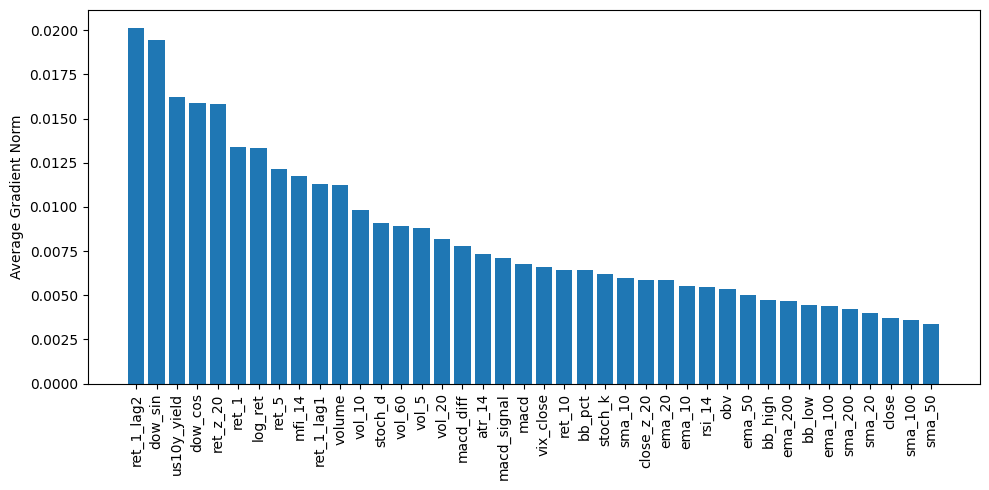

In [68]:
# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(bbb_sorted_labels)), bbb_sorted_values)
plt.xticks(range(len(bbb_sorted_labels)), bbb_sorted_labels, rotation=90)
plt.ylabel("Average Gradient Norm")
plt.tight_layout()
plt.show()